# Convert existing Tensorflow code to Ray AIR

If you already have working Tensorflow code, you don’t have to start from scratch to utilize the benefits of Ray AIR. Instead, you can continue to use your existing code and incrementally add Ray AIR components as needed.

Some of the benefits you’ll get by using Ray AIR with your existing Tensorflow training code:

- Easy distributed data-parallel training on a cluster
- Automatic checkpointing/fault tolerance and result tracking
- Parallel data preprocessing
- Seamless integration with hyperparameter tuning
- Scalable batch prediction
- Scalable model serving

This tutorial will show you how to start with Ray AIR from your existing Tensorflow training code. We will learn how to perform **distributed data-parallel training** and do **scalable batch prediction**.

## Example Code

The example code we’ll be using is that of the [Tensorflow quickstart tutorial](https://www.tensorflow.org/tutorials/quickstart/advanced). This code trains a convolutional neural network classifier on the MNIST dataset.

Follow along this example by launching the notebook using the 🚀 icon above!

## Existing Tensorflow Code

Let’s start with the unmodified code from the example. A thorough explanation of the parts is given in the full tutorial - we’ll just focus on the code here.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.9.2


First, we load and preprocess the MNIST dataset.

Note that we convert it to a native Tensorflow `tf.data.Dataset`. This may be the dataset that your existing code operates with, so this example will show that you don't need to replace every part of your ML pipeline at once.

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

N = 1024

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train[:N], y_train[:N])).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Next, we define the model architecture. One slight difference here between the Tensorflow quickstart is building the network as a `tf.keras.Sequential` model rather than as a class. This way of defining the model makes it easier to load weights and pass in as the "model definition" to batch prediction later.

In [2]:
def build_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model

We initialize the model, loss, optimizer, and define some metrics that we want to track during training.

In [ ]:
# Create an instance of the model
model = build_model()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

We define training and evaluation steps for a single batch of input data (a batch of images and their respective labels).

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)
        
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

Lastly, we have the training loop, which trains the model for some number of epochs. Each epoch will loop through the entire training dataset and perform gradient descent steps.

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

## Converting starter code to Keras Model.fit API

We recommend using the Keras `Model.fit` API, as it makes distributing your training much simpler with `tf.distribute` and AIR. Concretely, compile your model with a loss function and optimizer, then run `model.fit(dataset)` rather than iterating through dataset and applying gradients manually.

If your training requires custom logic and cannot use the `Model.fit` API, see here on how to proceed.

In [ ]:
# Create an instance of the model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

model = build_model()
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=["accuracy"],
)

The training loop roughly stays the same. Each epoch will fit and evaluate the model and then report some metrics.

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_history = model.fit(train_ds)
    eval_result = model.evaluate(test_ds, return_dict=True)

    train_result = {key: val[0] for key, val in train_history.history.items()}
    train_loss = train_result["loss"]
    train_accuracy = train_result["accuracy"]
    
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss}, '
        f'Accuracy: {train_accuracy * 100}, '
        f'Test Loss: {test_loss}, '
        f'Test Accuracy: {test_accuracy * 100}'
    )

## Wrap everything in a training loop function

Later on, we might want to perform hyperparameter optimization and launch multiple training runs, so it is useful to wrap the training logic we have so far in a function.

We also introduce a function to get the training and test datasets, which is used within the training function.

In [3]:
def get_train_test_datasets(batch_size):
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    N = 1024

    # Add a channels dimension
    x_train = x_train[..., tf.newaxis].astype("float32")
    x_test = x_test[..., tf.newaxis].astype("float32")

    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train[:N], y_train[:N])).shuffle(len(x_train)).batch(batch_size)

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    
    return train_ds, test_ds

def train_func():
    epochs = 5
    batch_size = 32

    # Create an instance of the model
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()

    model = build_model()
    model.compile(
        optimizer=optimizer,
        loss=loss_object,
        metrics=["accuracy"],
    )
    
    train_ds, test_ds = get_train_test_datasets(batch_size)
    
    for epoch in range(epochs):
        train_history = model.fit(train_ds)
        eval_result = model.evaluate(test_ds, return_dict=True)

        train_result = {key: val[0] for key, val in train_history.history.items()}
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]

        test_loss = eval_result["loss"]
        test_accuracy = eval_result["accuracy"]

        print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss}, '
            f'Accuracy: {train_accuracy * 100}, '
            f'Test Loss: {test_loss}, '
            f'Test Accuracy: {test_accuracy * 100}'
        )

## Introduce Ray AIR for Distributed Data-Parallel Training

AIR sets up the backend for initializing workers and managing communication between them. This way, you can use simply use `tf.distribute` to run your training loop across multiple workers in a DDP fashion!

As a first step, we want to distribute the training across multiple workers. For this we want to:

1. Use data-parallel training by sharding the training data
2. Setup the model to communicate gradient updates and synchronize model weights across workers
3. Report the results back to Ray AIR.

We only need change a few lines of code:

```python
from ray.air import session

# 1. Add a `config` argument to the train function to pass in hyperparameters
def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    # ...
    
    # 2. Wrap the model build and compilation within tf.distribute strategy scope
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()

        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    # ...
    
    # 3. Set a `global_batch_size` so that every worker gets the specified
    #    `batch_size_per_worker` regardless of the number of workers.
    #    This is needed because the dataset is sharded across workers.
    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)
```

A few notes on the `session` API introduced by Ray AIR:
- `session.get_world_size()` is a Ray AIR helper that gets the number of workers doing training.
- In the updated code below, we also use the helper `session.get_world_rank()` to only print logs on the head worker node (with rank 0) so that the output isn't spammed by logs from all workers.
- We will also use the `session` to report metrics and save/load checkpoints later!

In [14]:
from ray.air import session

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)

    # See note in this section: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#train_the_model
    # Must initialize strategy before other Tensorflow ops
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    # Wrap model definition and compilation within tf distributed strategy scope
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )
    
    # Dataset will be sharded across workers -- make sure each worker
    # gets the same batch_size regardless of # of workers
    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)

    if session.get_world_rank() == 0:
        print(f"\nDatset is sharded across {session.get_world_size()} workers:")
        # Approximate, because # samples is not always a multiple of batch_size
        print(f"# training batches per worker = {len(train_ds)} (~{len(train_ds) * batch_size_per_worker} samples)")
        print(f"# test batches per worker = {len(test_ds)} (~{len(test_ds) * batch_size_per_worker} samples)")
    
    for epoch in range(epochs):
        train_history = model.fit(train_ds, verbose=0)
        eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)

        train_result = {key: val[0] for key, val in train_history.history.items()}
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]

        test_loss = eval_result["loss"]
        test_accuracy = eval_result["accuracy"]

        # Let the head node 
        if session.get_world_rank() == 0:
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {train_loss}, '
                f'Accuracy: {train_accuracy * 100}, '
                f'Test Loss: {test_loss}, '
                f'Test Accuracy: {test_accuracy * 100}'
            )


Now we’ll use Ray Train’s `TensorflowTrainer` to kick off the distributed training.
- `train_loop_config` sets the hyperparmameters passed into the training loop as the `config` parameter
- `scaling_config` configures **how many parallel workers to use**, the **resources required per worker**, and whether we want to **enable GPU training** or not.

In [ ]:
from ray.train.tensorflow import TensorflowTrainer
from ray.air.config import ScalingConfig

num_workers = 4
resources_per_worker = {"CPU": 3}
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 5,
    },
    scaling_config=ScalingConfig(
        num_workers=num_workers,
        resources_per_worker=resources_per_worker,
        use_gpu=use_gpu,
    ),
)
result = trainer.fit()

Great, this works 🎉! You’re now training your model in parallel. You could now scale this up to more nodes and workers on your Ray cluster.

But there are a few improvements we can make to the code in order to get the most of the system. For one, we should enable checkpointing to get access to the trained model afterwards, as well as take advantage of the fault tolerance capabilities (training resume) of Ray AIR.

### Enable checkpointing to retrieve the model

We use `session.report` to report metrics and save checkpoints:
- The **metrics** will be logged to the experiment directory and visible to experiment analysis dashboards such as Tensorboard, or immediately available to us from the training result (ex: `result.metrics` or `results.metrics_dataframe` for a pandas dataframe).
- The **checkpoints** will be saved to the experiment directory for later use, or immediately available to us from the training result (ex:  `result.checkpoint`).

```python
def train_func(config: dict):
    
    # ...
    
    for epoch in range(epochs):
        
        # ...
        
        metrics = {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
        }
        checkpoint = Checkpoint.from_dict({
            "model": model.get_weights(),
            "optimizer_weights": optimizer.get_weights(),
            "epoch": epoch,
        })
        session.report(metrics, checkpoint=checkpoint)
```

Let's run the latest code with checkpoints!

In [76]:
from ray.air import session, Checkpoint

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)

    # See note in this section: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#train_the_model
    # Must initialize strategy before other Tensorflow ops
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    # Wrap model definition and compilation within tf distributed strategy scope
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )
        
    # NEW: Checkpoint loading
    starting_epoch = 0
    if session.get_checkpoint():
        checkpoint_dict = session.get_checkpoint().to_dict()
        # Load model weights
        model.set_weights(checkpoint_dict["model"])
        # Resume with the same optimizer state (ex: Adam)
        optimizer.set_weights(checkpoint_dict["optimizer_weights"])
        # Resume from the epoch we left off at (last reported epoch + 1)
        last_epoch = checkpoint_dict["epoch"]
        starting_epoch = last_epoch + 1
    
    # Dataset will be sharded across workers -- make sure each worker
    # gets the same batch_size regardless of # of workers
    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)
    
    if session.get_world_rank() == 0:
        print(f"\nDatset is sharded across {session.get_world_size()} workers:")
        # Approximate, because # samples is not always a multiple of batch_size
        print(f"# training batches per worker = {len(train_ds)} (~{len(train_ds) * batch_size_per_worker} samples)")
        print(f"# test batches per worker = {len(test_ds)} (~{len(test_ds) * batch_size_per_worker} samples)")
    
    # NEW: start from `starting_epoch`
    for epoch in range(starting_epoch, epochs):
        train_history = model.fit(train_ds, verbose=0)
        eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)

        train_result = {key: val[0] for key, val in train_history.history.items()}
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]

        test_loss = eval_result["loss"]
        test_accuracy = eval_result["accuracy"]

        # Let the head node 
        if session.get_world_rank() == 0:
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {train_loss}, '
                f'Accuracy: {train_accuracy * 100}, '
                f'Test Loss: {test_loss}, '
                f'Test Accuracy: {test_accuracy * 100}'
            )

        # NEW: Metric reporting and checkpoint saving
        metrics = {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
        }
        checkpoint = Checkpoint.from_dict({
            "model": model.get_weights(),
            "optimizer_weights": optimizer.get_weights(),
            "epoch": epoch,
        })
        session.report(metrics, checkpoint=checkpoint)


In [ ]:
from ray.train.tensorflow import TensorflowTrainer
from ray.air.config import ScalingConfig

num_workers = 4
resources_per_worker = {"CPU": 3}
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 5,
    },
    scaling_config=ScalingConfig(
        num_workers=num_workers,
        resources_per_worker=resources_per_worker,
        use_gpu=use_gpu,
    ),
)
result = trainer.fit()

<AxesSubplot: xlabel='training_iteration'>

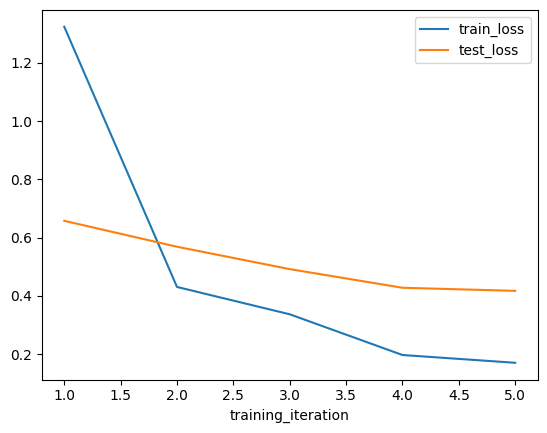

(RayTrainWorker pid=83742) Exception ignored in: <function Pool.__del__ at 0x7fdf8daa7ee0>
(RayTrainWorker pid=83742) Traceback (most recent call last):
(RayTrainWorker pid=83742)   File "/home/ray/anaconda3/lib/python3.8/multiprocessing/pool.py", line 268, in __del__
(RayTrainWorker pid=83742)     self._change_notifier.put(None)
(RayTrainWorker pid=83742)   File "/home/ray/anaconda3/lib/python3.8/multiprocessing/queues.py", line 368, in put
(RayTrainWorker pid=83742)     self._writer.send_bytes(obj)
(RayTrainWorker pid=83742)   File "/home/ray/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
(RayTrainWorker pid=83742)     self._send_bytes(m[offset:offset + size])
(RayTrainWorker pid=83742)   File "/home/ray/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
(RayTrainWorker pid=83742)     self._send(header + buf)
(RayTrainWorker pid=83742)   File "/home/ray/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in 

In [78]:
result.metrics_dataframe.plot("training_iteration", ["train_loss", "test_loss"])

## Using the trained model for prediction

The original Tensorflow quickstart doesn't actually go over loading the model for prediction, but let's see how you would complete the machine learning lifecycle with scalable batch prediction with Ray AIR!

### Loading the model for prediction

Here's how to load the model from a checkpoint and perform model inference on some sample data.

In [80]:
from ray.train.tensorflow import TensorflowCheckpoint

model = build_model()
model_weights = TensorflowCheckpoint.from_checkpoint(result.checkpoint).get_model_weights()

# Alternatively, from checkpoint directory
# model_weights = TensorflowCheckpoint.from_directory(checkpoint_path).get_model_weights()

# model_weights = Checkpoint.from_checkpoint(result.checkpoint).to_dict()["model_weights"]
model.set_weights(model_weights)

In [81]:
import matplotlib.pyplot as plt

def predict_from_model(model, image, label):
    logits = model(image.reshape((1, 28, 28, 1)), training=False)[0]
    pred = tf.argmax(logits)
    plt.imshow(image.reshape((28, 28)))
    print(f"Prediction = {pred}, Label = {label}")

In [82]:
_, test_ds = get_train_test_datasets(batch_size=1)
image, label = next(iter(test_ds))

Prediction = 7, Label = [7]


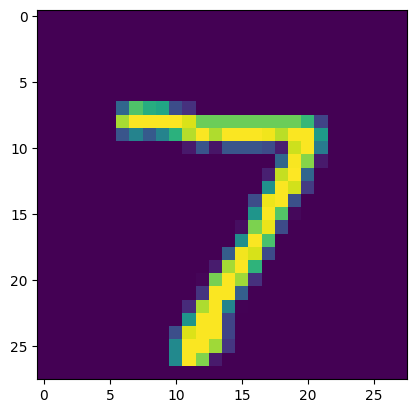

In [83]:
predict_from_model(model, image.numpy(), label.numpy())

### Using Ray AIR for scalable batch prediction

However, we can also use Ray AIR's `BatchPredictor` class to do scalable prediction.

To create the `BatchPredictor`, we use the `BatchPredictor.from_checkpoint` method to load a model created by `model_definition` with the trained weights stored in the checkpoint. Again, the checkpoint passed in could be instantiated using `Checkpoint.from_directory(checkpoint_path)` instead.

In [64]:
from ray.train.batch_predictor import BatchPredictor
from ray.train.tensorflow import TensorflowPredictor

batch_predictor = BatchPredictor.from_checkpoint(
    result.checkpoint,
    TensorflowPredictor,
    model_definition=build_model
)

Batch predictors work with Ray Datasets. Here we create a Ray Dataset of images from our test set.

TODO

In [65]:
from ray.data.datasource import SimpleTensorFlowDatasource

def factory():
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    return tf.data.Dataset.from_tensor_slices(x_test).batch(32)

# TODO: This doesn't actually work as input to BatchPredictor...
test_images_ds = ray.data.read_datasource(
    SimpleTensorFlowDatasource(),
    parallelism=1,
    dataset_factory=factory,
)

In [69]:
def get_test_data():
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    return x_test, y_test

x_test, y_test = get_test_data()
test_images_ds = ray.data.from_items(x_test)

Let's run `BatchPredictor.predict` on our Ray Dataset. This will distribute the prediction across a specified number of workers!

In [70]:
predict_results = batch_predictor.predict(test_images_ds)

Map Progress (1 actors 1 pending):   0%|          | 1/200 [00:06<19:59,  6.03s/it](BlockWorker pid=82925) 2022-09-28 17:15:27.762025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(BlockWorker pid=82925) 2022-09-28 17:15:27.762069: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Map_Batches: 100%|██████████| 200/200 [00:00<00:00, 212.89it/s]


Prediction Accuracy = 0.8679


(BlockWorker pid=83004) 2022-09-28 17:15:33.323230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(BlockWorker pid=83004) 2022-09-28 17:15:33.323265: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


`predict_results` is also a Ray Dataset, and we can take a look at the predictions inside:

In [ ]:
predict_results.show()

Our model outputs logits, but we want the actual predicted labels. We can convert the logits to labels by performing a map on `predict_results`, taking the `argmax` of each model output. Then, we can compute the accuracy by comparing to the test set labels!

In [ ]:
predicted_classes = predict_results.map_batches(
    lambda batch: [pred.argmax(0) for pred in batch["predictions"]], 
    batch_format="pandas"
)
predicted_classes_np = predicted_classes.take_all()

pred_accuracy = (predicted_classes_np == y_test).astype(int).sum() / len(predicted_classes_np)
print("Prediction Accuracy =", pred_accuracy)

## Summary

This tutorial demonstrated how to turn your existing PyTorch code into code you can use with Ray AIR.

We learned how to:
- enable distributed training using Ray Train abstractions
- save and retrieve model checkpoints via Ray AIR
- load a model for batch prediction

In our other examples you can learn how to do more things with the Ray AIR API, such as serving your model with Ray Serve or tune your hyperparameters with Ray Tune. You can also learn how to construct Ray Datasets to leverage Ray AIR’s preprocessing API.

We hope this tutorial gave you a good starting point to leverage Ray AIR. If you have any questions, suggestions, or run into any problems pelase reach out on Discuss or GitHub!

## Using ray.data

In [ ]:
import tensorflow as tf

import ray
from ray.air import session, RunConfig
from ray.air.callbacks.keras import Callback
from ray.train.tensorflow import prepare_dataset_shard
from ray.train.tensorflow import TensorflowTrainer, TensorflowCheckpoint
from ray.air.config import ScalingConfig
from ray import tune
from ray.tune import Tuner

def build_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model

def to_tf_dataset(dataset, batch_size):
    def to_tensor_iterator():
        for batch in dataset.iter_tf_batches(
            batch_size=batch_size, dtypes=tf.float32
        ):
            yield batch["x"], batch["y"]

    output_signature = (
        tf.TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None), dtype=tf.float32),
    )
    tf_dataset = tf.data.Dataset.from_generator(
        to_tensor_iterator, output_signature=output_signature
    )
    return prepare_dataset_shard(tf_dataset)

def train_func(config: dict):
    batch_size = config.get("batch_size", 32)
    epochs = config.get("epochs", 3)
    starting_epoch = 0
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_model()
        multi_worker_model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[],
        )
        
        if session.get_checkpoint():
            if session.get_world_rank() == 0:
                print("Loading checkpoint...")
            checkpoint = TensorflowCheckpoint.from_checkpoint(session.get_checkpoint())
            model_weights = checkpoint.get_model_weights()
            multi_worker_model.set_weights(model_weights)
            
            last_epoch = session.get_checkpoint().to_dict()["training_iteration"]
            starting_epoch = last_epoch + 1

    print("\nGetting dataset shard...\n")
    dataset = session.get_dataset_shard("train")
    if session.get_world_rank() == 0:
        print("Sharded dataset size:", dataset.count())
        print("World size:", session.get_world_size())

    results = []
    for epoch in range(starting_epoch, epochs):
        tf_dataset = to_tf_dataset(dataset=dataset, batch_size=batch_size)
        if session.get_world_rank() == 0:
            print(f"\nEpoch {epoch} ------------------------")
        history = multi_worker_model.fit(
            tf_dataset,
            epochs=1,
            steps_per_epoch=dataset.count() // batch_size,
            callbacks=[Callback()],
            verbose=0,
        )
        if session.get_world_rank() == 0:
            print("\nLoss =", history.history["loss"][-1])
        results.append(history.history)
    return results


In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

N = 1024 * 10
train_ds = ray.data.from_items([
    {"x": x, "y": y}
    for x, y in zip(x_train[:N], y_train[:N])
#     for x, y in zip(x_train, y_train)
])

test_ds = ray.data.from_items([
    {"x": x, "y": y}
    for x, y in zip(x_test, y_test)
])

In [ ]:
num_workers = 4
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 10,
    },
    scaling_config=ScalingConfig(
        num_workers=num_workers,
        resources_per_worker={"CPU": 4},
        use_gpu=use_gpu,
    ),
    datasets={"train": train_ds, "valid": test_ds},
)
results_grid = trainer.fit()
# tuner = Tuner(
#     trainer,
#     param_space={
#         "train_loop_config": {
#             "batch_size": 32,
#             "epochs": 10,
#         }
#     },
#     run_config=RunConfig(name="test_ds_restore"),
#     tune_config=tune.TuneConfig(metric="loss", mode="min", num_samples=1),
# )
# results_grid = tuner.fit()